In [16]:
import intake
import xarray as xr
import numpy as np
import pandas as pd
import datetime as dt
from skimage.segmentation import find_boundaries
import xesmf as xe
import dask.array as da
import scipy
from dask.distributed import progress
import pyproj
import warnings
import healpy as hp
import easygems.healpix as egh
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import glob
from dask.distributed import Client

In [52]:
def get_nn_lon_lat_index(nside, lons, lats):
    """
    Interpolate from healpix to regular lat lon
    
    nside: integer, power of 2. The return of hp.get_nside()
    lons: uniques values of longitudes
    lats: uniques values of latitudes
    returns: array with the HEALPix cells that are closest to the lon/lat grid
    """
    lons2, lats2 = np.meshgrid(lons, lats)
    return xr.DataArray(
        hp.ang2pix(nside, lons2, lats2, nest = True, lonlat = True),
        coords=[("lat", lats), ("lon", lons)],
    )

def rotate_wind(u,v,theta):

    """
    Rotate u and v wind components to be cross-shore and along-shore, based on angle of coastline orientation, theta.

    ## Input
    * u: xarray dataarray of u winds in m/s
    * v: xarray dataarray of v winds in m/s
    * theta: xarray dataarray of coastline orientation angles from N

    ## Output
    * uprime: xarray dataarray of wind component parallel to the coast
    * vprime: xarray dataarray of wind component perpendicular to the coast
    """

    #Rotate angle to be perpendicular to theta, from E (i.e. mathamatical angle definition)
    rotated_angle=(((theta)%360-90)%360) + 90   
    
    #Define normal angle vectors, pointing onshore
    cx, cy = [-np.cos(np.deg2rad(rotated_angle)), np.sin(np.deg2rad(rotated_angle))]
    
    #Define normal angle vectors, pointing alongshore
    ax, ay = [-np.cos(np.deg2rad(rotated_angle - 90)), np.sin(np.deg2rad(rotated_angle - 90))]    
    
    #Calculate the wind component perpendicular and parallel to the coast by using the normal unit vectors
    uprime = ((u*ax) + (v*ay))
    vprime = ((u*cx) + (v*cy))

    return uprime, vprime    

def interpolate_variance(angle_ds):

    """
    From a dataset of coastline angle variance, interpolate across the coastline.
    """

    xx,yy = np.meshgrid(angle_ds.lon,angle_ds.lat)

    points = angle_ds.variance.values.ravel()
    valid = ~np.isnan(points)
    points_valid = points[valid]
    xx_rav, yy_rav = xx.ravel(), yy.ravel()
    xxv = xx_rav[valid]
    yyv = yy_rav[valid]
    interpolated_variance = scipy.interpolate.griddata(np.stack([xxv, yyv]).T, points_valid, (xx, yy), method="linear").reshape(xx.shape)     
    interpolated_variance_da = xr.DataArray(interpolated_variance,dims=angle_ds.dims,coords=angle_ds.coords)

    angle_ds["variance_interp"] = interpolated_variance_da

    return angle_ds

def interpolate_angles(angle_ds):

    """
    From a dataset of coastline angles, interpolate across the coastline.

    This is used because the result of get_coastline_angle_kernel() is not defined along the coastline.
    """

    xx,yy = np.meshgrid(angle_ds.lon,angle_ds.lat)

    mean_complex = angle_ds.mean_abs * da.exp(1j*angle_ds.mean_angles)
    points = mean_complex.values.ravel()
    valid = ~np.isnan(points)
    points_valid = points[valid]
    xx_rav, yy_rav = xx.ravel(), yy.ravel()
    xxv = xx_rav[valid]
    yyv = yy_rav[valid]
    interpolated_angles = scipy.interpolate.griddata(np.stack([xxv, yyv]).T, points_valid, (xx, yy), method="linear").reshape(xx.shape) 

    interpolated_angles = da.rad2deg(da.angle(interpolated_angles))
    interpolated_angle_da = xr.DataArray(interpolated_angles - 90,coords={"lat":angle_ds.lat,"lon":angle_ds.lon})
    interpolated_angle_da = xr.where(interpolated_angle_da < 0, interpolated_angle_da+360, interpolated_angle_da)  

    angle_ds = angle_ds.drop_vars(["mean_abs","mean_angles"])
    angle_ds["angle_interp"] = interpolated_angle_da

    return angle_ds

def get_weights(x, p=4, q=2, R=5, slope=-1, r=10000):
    """
    Calculate weights for averaging angles between pixels and coastlines
    
    Method:
    x the distance
    Let y1 = m1 * (x / R) ** (-p) for x > R.
    Let y2 = S - m2 * (x / R) ** (q) for x <= R.
    Equate y1 and y2 and their derivative at x = R to get
    S = m1 + m2
    slope = -p * m1 = -q * m2 => m1 = -slope/p and m2 = -slope/q
    Thus specifying p, q, R, and the function's slope at x=R determines m1, m2 and S.

    # Inputs

    * x: Distance (array like)

    * p: Inverse power to decrease weights after distance R (float)

    * q: Inverse power to decrease weights before distance R (float)

    * R: Distance (in x) to change inverse weighting power from p to q

    * slope: Slpe of function at point R

    * r: The distance at which the weights go to zero (to avoid overflows)

    From Ewan Short
    """
    m1 = -slope/p
    m2 = -slope/q
    S = m1 + m2
    y = da.where(x>R,  m1 * (x / R) ** (-p), S - m2 * (x / R) ** (q))
    y = da.where(x==0, np.nan, y)
    y = da.where(x>r, 0, y)
    return y

def get_coastline_angle_kernel(lsm=None,R=20,latlon_chunk_size=10,compute=True,path_to_load=None,save=False,path_to_save=None,lat_slice=None,lon_slice=None,smooth=False,sigma=4):

    '''
    Ewan's method with help from Jarrah.
    
    Construct a "kernel" for each coastline point based on the angle between that point and all other points in the domain, then take a weighted average. The weighting function can be customised, but is by default an inverse parabola to distance R, then decreases by distance**4. The weights are set to zero at a distance of 2000 km, and are undefined at the coast (where linear interpolation is done to fill in the coastline gaps)

    ## Input
    * lsm: xarray dataarray with a binary lsm, and lat lon info

    * R: the distance (in km) at which the weighting function is changed from 1/p to 1/q. See get_weights function. Should be approximately 2 times the grid spacing of the lsm

    * coast_dim_chunk_size: the size of the chunks over the coastline dimension

    * extend_lon: only valid for global data that is periodic in longitude (with lons ranging from -180 to 180). How many pixels to extend the east and west boundary? Noting that pixels at the extreme east/west of the domain could be impacted by coastlines on the opposite boundary. The value given (int) will extend the E/W boundary by as many pixels.

    * compute: boolean whether or not to actually compute the angles, or just load from disk (in which case path_to_load must be specified)

    * path_to_load: file path to previous output that can be loaded

    * save: boolean - save the angles output?

    * path_to_save: file path to save output

    * lat_slice: if not computing, lats to slice when loading angles from disk

    * lat_slice: if not computing, lons to slice when loading angles from disk

    * smooth: boolean - smooth the interpolated angles output using a gaussian filter. All other output (variance, non-interpolated angles, coastline, min coast distance) is not smoothed

    * sigma: if smoothing, the sigma of the gaussian filter 

    ## Output
    * An xarray dataset with an array of coastline angles (0-360 degrees from N) for the labelled coastline array, as well as an array of angle variance as an estimate of how many coastlines are influencing a given point
    '''

    if save:
        if path_to_save is None:
            raise AttributeError("Saving but no path speficfied")
        
    if compute:

        assert np.in1d([0,1],np.unique(lsm)).all(), "Land-sea mask must be binary"
        
        warnings.simplefilter("ignore")

        #From the land sea mask define the coastline and a label array
        coast_label = find_boundaries(lsm)*1
        land_label = lsm.values

        #Get lat lon info for domain and coastline, and convert to lower precision
        lon = lsm.lon.values
        lat = lsm.lat.values
        xx,yy = np.meshgrid(lon,lat)
        xx = xx.astype(np.float32)
        yy = yy.astype(np.float32)    

        #Define coastline x,y indices from the coastline mask
        xl, yl = np.where(coast_label)

        #Get coastline lat lon vectors
        yy_t = np.array([yy[xl[t],yl[t]] for t in np.arange(len(yl))])
        xx_t = np.array([xx[xl[t],yl[t]] for t in np.arange(len(xl))])

        #Repeat the 2d lat lon array over a third dimension (corresponding to the coast dim). Also repeat the yy_t and xx_t vectors over the spatial arrays
        yy_rep = da.moveaxis(da.stack([da.from_array(yy)]*yl.shape[0],axis=0),0,-1).rechunk({0:-1,1:-1,2:latlon_chunk_size})
        xx_rep = da.moveaxis(da.stack([da.from_array(xx)]*xl.shape[0],axis=0),0,-1).rechunk({0:-1,1:-1,2:latlon_chunk_size})
        xx_t_rep = (xx_rep * 0) + xx_t
        yy_t_rep = (yy_rep * 0) + yy_t

        #Calculate the distance and angle between coastal points and all other points using pyproj, then convert to complex space.
        geod = pyproj.Geod(ellps="WGS84")
        def calc_dist(lon1,lat1,lon2,lat2):
            fa,_,d = geod.inv(lon1,lat1,lon2,lat2)
            return d/1e3 * np.exp(1j * np.deg2rad(fa))
        
        stack = da.map_blocks(
                    calc_dist,
                    xx_t_rep,
                    yy_t_rep,
                    xx_rep,
                    yy_rep,
                    dtype=np.complex64,
                    meta=np.array((), dtype=np.complex64))
        del xx_t_rep, yy_t_rep, yy_rep, xx_rep
        
        #Move axes around for convenience later
        stack = da.moveaxis(stack, -1, 0)

        #Get back distance by taking absolute value
        stack_abs = da.abs(stack,dtype=np.float32)
        
        #Create an inverse distance weighting function
        weights = get_weights(stack_abs, p=4, q=2, R=R, slope=-1)

        #Take the weighted mean and convert complex numbers to an angle and magnitude
        print("INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...")
        mean_angles = da.mean((weights*stack), axis=0).persist()
        progress(mean_angles)
        mean_abs = da.abs(mean_angles)
        mean_angles = da.angle(mean_angles)    

        #Flip the angles inside the coastline for convention, and convert range to 0 to 2*pi
        mean_angles = da.where(land_label==1,(mean_angles+np.pi) % (2*np.pi),mean_angles % (2*np.pi))

        #Calculate the weighted circular variance
        print("INFO: Calculating the sum of the weights...")
        total_weight = da.sum(weights, axis=0).persist()
        progress(total_weight)
        print("INFO: Calculating variance...")
        variance = (1 - da.abs(da.sum( (weights/total_weight) * (stack / stack_abs), axis=0))).persist()
        progress(variance)
        del stack, weights, total_weight 

        #Calculate minimum distance to the coast
        print("INFO: Calculating minimum distance to the coast...")
        min_coast_dist = stack_abs.min(axis=0).persist()

        #Convert angles to degrees, and from bearing to orientation of coastline.
        #Also create an xr dataarray object
        angle_da = xr.DataArray(da.rad2deg(mean_angles) - 90,coords={"lat":lat,"lon":lon})
        angle_da = xr.where(angle_da < 0, angle_da+360, angle_da)      

        #Convert variance and coast arrays to xr dataarrays
        var_da = xr.DataArray(variance,coords={"lat":lat,"lon":lon})
        coast = xr.DataArray(coast_label,coords={"lat":lat,"lon":lon})
        mean_abs = xr.DataArray(mean_abs,coords={"lat":lat,"lon":lon})
        mean_angles = xr.DataArray(mean_angles,coords={"lat":lat,"lon":lon})
        min_coast_dist = xr.DataArray(min_coast_dist,coords={"lat":lat,"lon":lon})

        #Create an xarray dataset
        angle_ds =  xr.Dataset({
            "angle":angle_da,
            "variance":var_da,
            "coast":coast,
            "mean_abs":mean_abs,
            "mean_angles":mean_angles,
            "min_coast_dist":min_coast_dist})

        #Do the interpolation across the coastline
        angle_ds = interpolate_angles(angle_ds)
        angle_ds = interpolate_variance(angle_ds)

        #Attributes
        angle_ds["angle"] = angle_ds["angle"].assign_attrs(
            units = "degrees",
            long_name = "Angle of coastline orientation",
            description = "The angle of dominant coastline orientation in degrees from North. Points with a dominant north-south coastline with ocean to the east will have an angle of 0 degrees. The dominant coastline for each point is determined by the weighted mean of the angles between that point and all coastline points in the domain. The weighting function is an inverse parabola to distance R, then decreases by distance**4. The weights are set to zero at a distance of 2000 km, and are undefined at the coast."
            )
        
        angle_ds["variance"] = angle_ds["variance"].assign_attrs(
            units = "[0,1]",
            long_name = "Variance of coastline angles",
            description = "For each point, the variance of the coastline angles in the domain. This is a measure of how many coastlines are influencing a given point. A value of 0 indicates that coastlines are generally in agreement, and a value of 1 indicates that the point is influenced by coastlines in all directions."
            )
        
        angle_ds["coast"] = angle_ds["coast"].assign_attrs(
            units = "[0,1]",
            long_name = "Coastline mask",
            description = "A binary mask of the coastline determined from the land-sea mask. 1 indicates a coastline point, and 0 indicates a non-coastline point."
            )
        
        angle_ds["min_coast_dist"] = angle_ds["min_coast_dist"].assign_attrs(
            units = "km",
            long_name = "Minimum distance to the coast",
            description = "The minimum distance to the coast for each point in the domain."
            )
        
        angle_ds["angle_interp"] = angle_ds["angle_interp"].assign_attrs(
            units = "degrees",
            long_name = "Interpolated coastline orientation",
            description = "The angle of dominant coastline orientation in degrees from North. Points with a dominant north-south coastline with ocean to the east will have an angle of 0 degrees. The dominant coastline for each point is determined by the weighted mean of the angles between that point and all coastline points in the domain. The weighting function is an inverse parabola to distance R, then decreases by distance**4. The weights are set to zero at a distance of 2000 km, and are undefined at the coast, where linear interpolation is then done."
            )
        
        angle_ds["variance_interp"] = angle_ds["variance_interp"].assign_attrs(
            units = "[0,1]",
            long_name = "Interpolated variance of coastline angles",
            description = "For each point, the variance of the coastline angles in the domain. This is a measure of how many coastlines are influencing a given point. A value of 0 indicates that coastlines are generally in agreement, and a value of 1 indicates that the point is influenced by coastlines in all directions. The variance is undefined at the coast, and here the variance is interpolated across the coastline."
            )
        
        angle_ds = angle_ds.assign_attrs(
            description = "Dataset of coastline angles and variance",
            acknowledgmements = "This method was developed with help from Ewan Short and Jarrah Harrison-Lofthouse.",
            R_km = str(R)
            )

    else:

        if path_to_load is not None:
            angle_ds = xr.open_dataset(path_to_load)
            if lat_slice is not None:
                angle_ds = angle_ds.sel(lat=lat_slice)
            if lon_slice is not None:
                angle_ds = angle_ds.sel(lon=lon_slice)
            save = False
        else:
            raise AttributeError("If not computing the angles, path_to_load needs to be specified")

    if save:
        angle_ds.to_netcdf(path_to_save)

    if smooth:
        angle_ds["angle_interp"] = smooth_angles(angle_ds["angle_interp"],sigma)

    return angle_ds

In [18]:
client = Client()

In [19]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46681/status,
Dashboard: /proxy/46681/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34943,Workers: 0
Dashboard: /proxy/46681/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33943,Total threads: 1
Dashboard: /proxy/33833/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:37713,


In [20]:
#Open some sample data
ds = xr.open_zarr("/scratch/nf33/Healpix_data/ICON/PT1H_inst_z1_atm.zarr/")

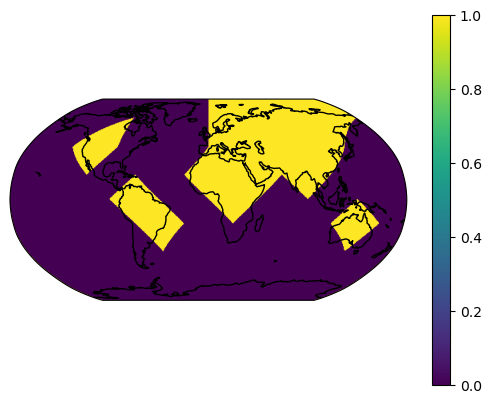

In [21]:
#Plot the healpix grid land sea mask
ax=plt.axes(projection=ccrs.Robinson(central_longitude=0))
ax.set_global()
im = egh.healpix_show(ds.sftlf>=0.5,ax=ax)
ax.coastlines()
plt.colorbar(im)

In [22]:
#Get the "nside", which is used for regridding
nside = hp.get_nside(ds.uas)

In [55]:
#Set up target latitude and longitude (regular grid) to interpolate onto
target_lats = np.linspace(
    -90,
    90,
    20#,int(np.round(np.sqrt(ds.cell.shape[0])))
)
target_lons = np.linspace(
    0,
    360,
    20#,int(np.round(np.sqrt(ds.cell.shape[0])))
)

#Do the interpolation and return the healpix cell indices
target_inds = get_nn_lon_lat_index(nside, target_lons, target_lats)

#Define the regridded land sea mask
lsm = ((ds.sftlf.isel(cell=target_inds))>0.5)

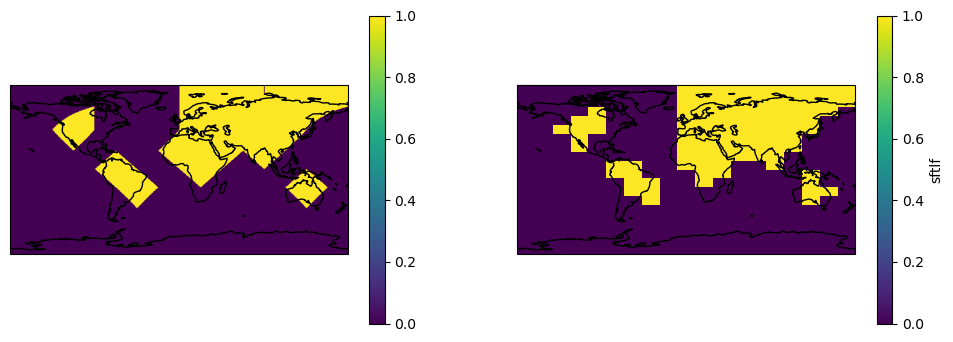

In [56]:
#Compare the healpix land sea mask with the regridded land sea mask

plt.figure(figsize=[12,4])
ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree(central_longitude = 0.0))
ax.set_global()
im = egh.healpix_show(ds.sftlf>=0.5,ax=ax)
ax.coastlines()
plt.colorbar(im)

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
im=((ds.sftlf.isel(cell=target_inds))>0.5).plot(ax=ax, transform = ccrs.PlateCarree())
ax.coastlines()

In [57]:
#From the land sea mask, define dominant coastline angles through the whole domain.
#R specifies the smoothing of nearby points, in the inverse distance weighting function (see get_weights())
angle_ds = get_coastline_angle_kernel(lsm,R=6000)    

INFO: Take the weighted mean and convert complex numbers to an angle and magnitude...
INFO: Calculating the sum of the weights...
INFO: Calculating variance...
INFO: Calculating minimum distance to the coast...


/scratch/nf33/public/miniconda/envs/digital_earths_env/lib/python3.12/site-packages/dask/_task_spec.py:758: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


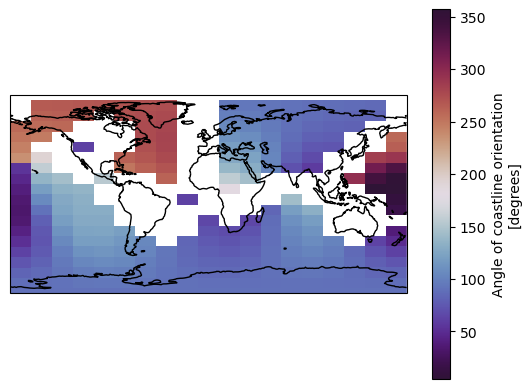

In [63]:
#Plot the coastline angles
ax=plt.axes(projection=ccrs.PlateCarree())
im=angle_ds.angle.plot(ax=ax, transform = ccrs.PlateCarree(), cmap="twilight_shifted")
ax.coastlines()

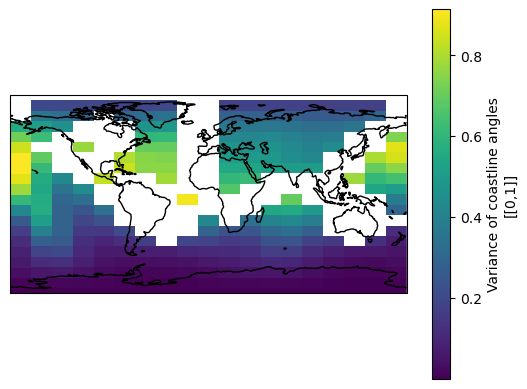

In [59]:
#Plot the coastline variance
ax=plt.axes(projection=ccrs.PlateCarree())
im=angle_ds.variance.plot(ax=ax, transform = ccrs.PlateCarree())
ax.coastlines()

In [60]:
#Regrid the u and v winds in the same way as the land-sea mask
uas_regrid = ds.uas.isel(cell=target_inds)
vas_regrid = ds.vas.isel(cell=target_inds)

In [61]:
#Rotate these winds to find the component perpendicular to the coastline (vprime)
_,vprime = rotate_wind(uas_regrid,vas_regrid,angle_ds.angle_interp)

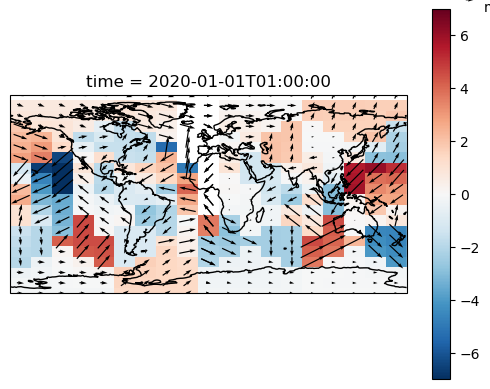

In [62]:
#Plot vprime and associated wind vectors for the first model time step
ax=plt.axes(projection=ccrs.PlateCarree())
im=vprime.isel(time=0).plot(ax=ax, transform = ccrs.PlateCarree())
xr.Dataset(
    {"u":uas_regrid,
    "v":vas_regrid}).isel(time=0).plot.quiver(
    x="lon",
    y="lat",
    u="u",
    v="v")
ax.coastlines()